In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import socket, struct
import netaddr
from sklearn.cluster import KMeans



In [11]:
tp = pd.read_csv('capture20110818.pcap.netflow.labeled.csv', chunksize=1000)
df = pd.concat(tp, ignore_index=True)


#preprocessing
df = df[df['Label']!='Background']

ips = df['SrcIPAddr:Port'].str.split(':')
df['SrcIPAddr'] = ips.str[0]
df['SrcIPPort'] = ips.str[-1]
ips = df['DstIPAddr:Port'].str.split(':')
df['DstIPAddr'] = ips.str[0]
df['DstIPPort'] = ips.str[-1]

df = df.drop(['Date', 'Flow_start', 'tmp', 'Flows', 'SrcIPAddr:Port', 'DstIPAddr:Port'], axis=1)
df.head()

,Durat,Prot,Flags,Tos,Packets,Bytes,Label,Labels,SrcIPAddr,SrcIPPort,DstIPAddr,DstIPPort
20,4.985,TCP,PA_,0,91,86277,LEGITIMATE,NaN,147.32.80.13,80,147.32.85.88,56949
51,0.000,TCP,A_,0,1,66,LEGITIMATE,NaN,147.32.86.110,48102,74.125.232.214,443
57,4.921,TCP,A_,0,49,3234,LEGITIMATE,NaN,147.32.85.88,56949,147.32.80.13,80
73,4.742,TCP,A_,0,118,7080,LEGITIMATE,NaN,147.32.84.59,2768,74.125.108.208,80
75,0.000,TCP,A_,0,1,60,LEGITIMATE,NaN,147.32.84.59,56058,74.125.232.215,443


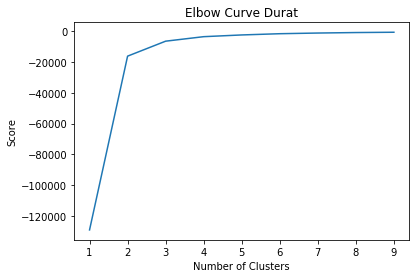

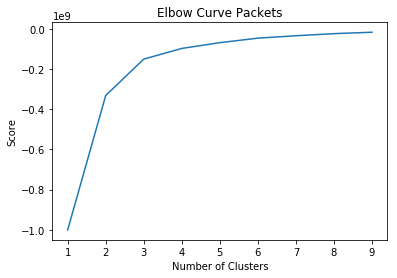

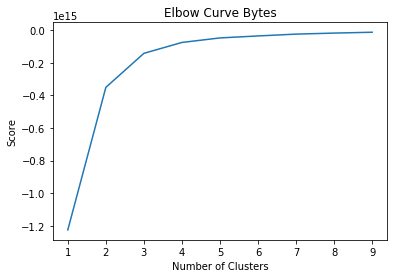

In [12]:
#clusters numerical
df_numerical = df[['Durat', 'Packets', 'Bytes']]
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
for column in df_numerical:
    X = df_numerical[column].values.reshape(-1, 1)
    score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
    plt.plot(Nc,score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Curve '+str(column))
    plt.show()

In [13]:
#elbow value identified from the above graphs
elbow = {'Durat': 2, 'Packets': 3, 'Bytes': 3}
for column in df_numerical:
    X = df_numerical[column].values.reshape(-1, 1)
    kmeans = KMeans(n_clusters=elbow[column], random_state=0).fit(X)
    df_numerical[column] = kmeans.labels_
    
df_numerical.head()

C:\Users\Anna\AppData\Local\Programs\Python\Python36-32\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Durat,Packets,Bytes
20,0,0,0
51,1,0,0
57,0,0,0
73,0,0,0
75,1,0,0


In [14]:
#clusters text
df_text = df[['Prot', 'Flags', 'Tos', 'SrcIPPort', 'DstIPAddr', 'DstIPPort']] 
for column in df_text:
    labels, levels = pd.factorize(df_text[column])
    df_text[column] = labels

df_text.head()

C:\Users\Anna\AppData\Local\Programs\Python\Python36-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Prot,Flags,Tos,SrcIPPort,DstIPAddr,DstIPPort
20,0,0,0,0,0,0
51,0,1,0,1,1,1
57,0,1,0,2,2,2
73,0,1,0,3,3,2
75,0,1,0,4,4,1


In [15]:
df_discrete = pd.concat([df_text, df_numerical], axis=1)
df_discrete = df_discrete[['Prot','Bytes']]
code = 0
spaceSize = 1
for column in df_discrete:
    spaceSize = spaceSize * df_discrete[column].value_counts(dropna=True).count()
    
df_discrete.head()

,Prot,Bytes
20,0,0
51,0,0
57,0,0
73,0,0
75,0,0


In [ ]:

codes = np.array([])
spaceSizeCurrent = spaceSize
for index, row in df_discrete.iterrows():
    for column in df_discrete:
        if (row[column] >= 0):
            code  = code + (row[column] * spaceSizeCurrent / df_discrete[column].value_counts(dropna=True).count())
            spaceSizeCurrent =  spaceSizeCurrent / df_discrete[column].value_counts(dropna=True).count()

    codes = np.append(codes,code)
    spaceSizeCurrent = spaceSize
    code = 0


df_discrete['codes'] = codes
df = pd.concat([df_discrete,df[['SrcIPAddr','Label']]], axis=1)
df.head()